In [1]:
#Imports
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [2]:
# Import data
train = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/train.csv'
df_train_raw = pd.read_csv(train)

test_x = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/test.csv'
df_test_x_raw = pd.read_csv(test_x)

test_y = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/sample_submission.csv'
df_test_y_raw= pd.read_csv(test_y)

In [3]:
# Merge train dataset and test dataset
df_test_raw = pd.merge(df_test_x_raw, df_test_y_raw, on='Id')
df_raw = pd.concat([df_train_raw,df_test_raw])

In [4]:
# From the data description, when these values are nan, the property does not contain installment. 
# So we will change these features from nan to None
na_none = ['Alley','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
     'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

In [5]:
# Check percentage of missing data for each feature in train dataset
na_col = [i for i in df_raw.columns if df_raw[i].isnull().sum() > 0 and i not in na_none]
print((df_raw[na_col].isna().sum()/len(df_raw.Id)).sort_values())

BsmtUnfSF       0.000343
GarageCars      0.000343
KitchenQual     0.000343
Electrical      0.000343
TotalBsmtSF     0.000343
GarageArea      0.000343
BsmtFinSF2      0.000343
SaleType        0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
BsmtFinSF1      0.000343
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
Utilities       0.000685
Functional      0.000685
MSZoning        0.001370
MasVnrArea      0.007879
MasVnrType      0.008222
GarageYrBlt     0.054471
LotFrontage     0.166495
dtype: float64


In [6]:
def clean_df(df):
    
    for col in df.columns:
        
        # Replace the missing value to None if feature is in the na_none list
        if col in na_none:
            df[col] =  df[col].fillna('None')
        
        # Drop features that contain more than 20% missing values
        elif df[col].isnull().sum() / df.shape[0] > 0.1:
            df = df.drop(col, axis=1)
            
    return df

In [7]:
df_cleaned = clean_df(df_raw) # drop columns and replace nan with none

df_cleaned = df_cleaned.dropna() #drop any row with missing data

In [8]:
#Drop ID column
df_cleaned = df_cleaned.drop('Id', axis=1)

# split train dataset
df_x = df_cleaned.drop(columns='SalePrice')
df_y = df_cleaned['SalePrice']

df_x.shape

(2726, 78)

In [9]:
df_cleaned

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,None,None,None,0,2,2008,WD,Normal,208500.000000
1,20,RL,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,...,0,None,None,None,0,5,2007,WD,Normal,181500.000000
2,60,RL,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,...,0,None,None,None,0,9,2008,WD,Normal,223500.000000
3,70,RL,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,...,0,None,None,None,0,2,2006,WD,Abnorml,140000.000000
4,60,RL,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,...,0,None,None,None,0,12,2008,WD,Normal,250000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,20,RL,13384,Pave,None,Reg,Lvl,AllPub,Inside,Mod,...,0,None,None,None,0,5,2006,WD,Normal,188506.431412
1452,160,RM,1533,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,None,None,None,0,12,2006,WD,Abnorml,172917.456816
1455,160,RM,1894,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,None,None,None,0,4,2006,WD,Abnorml,164788.778231
1456,20,RL,20000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,None,None,None,0,9,2006,WD,Abnorml,219222.423400


In [10]:
## ILAN, y-test summary stats
feature_names = list(df_cleaned.columns)
print("List of features:", feature_names)

List of features: ['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', '

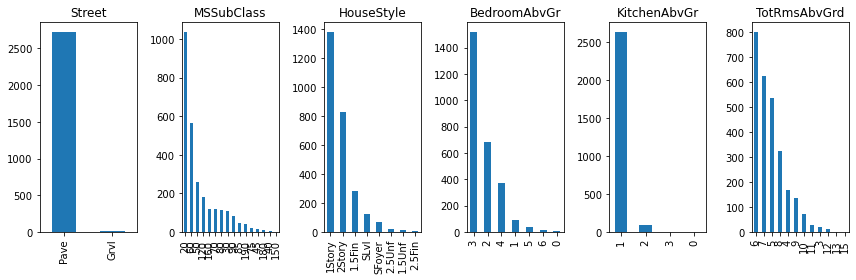

In [11]:
# Plot a small multiple of bar charts
fig, ax = plt.subplots(1, 6, figsize=(12, 4))
for i, var in enumerate(['Street', 'MSSubClass', 'HouseStyle', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']):
    df_cleaned[var].value_counts().plot(kind='bar', ax=ax[i])
    ax[i].set_title(var)

plt.tight_layout()
plt.show()

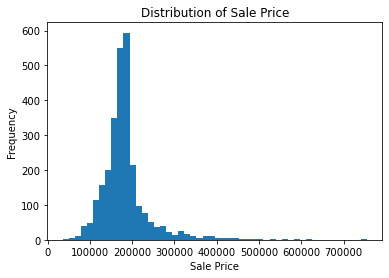

In [12]:
# assume 'SalePrice' is the target variable in your dataframe
y = df_cleaned['SalePrice']

# create a histogram of the target variable
plt.hist(y, bins=50)
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Distribution of Sale Price')
plt.show()

In [13]:
#Calculating y-test summary stats
mean = np.mean(df_y)
median = np.median(df_y)
std_dev = np.std(df_y)
skewness = df_y.skew()
kurtosis = df_y.kurtosis()

print("Mean: ", mean)
print("Median: ", median)
print("Standard Deviation: ", std_dev)
print("Skewness: ", skewness)
print("Kurtosis: ", kurtosis)

Mean:  182095.9275635585
Median:  177283.0649785215
Standard Deviation:  57113.81445708518
Skewness:  2.7171520639784874
Kurtosis:  15.42907052826676


In [14]:
## Seb Encoding, Correlation and Clustering

#List categorical features
categorical_feats = df_x.select_dtypes('object').columns
categorical_feats

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [15]:
# Encode variables

# Target Encode features that have many groups / are not ordinal
target_cat_feats = ['GarageType', 'Functional', 'Electrical', 'SaleCondition', 'SaleType', 'Heating', 'BsmtFinType2', 'BsmtFinType1', 'Foundation', 'MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType']
target_encoder = ce.TargetEncoder(cols=target_cat_feats)

target_encoder.fit(df_x, df_y)
df_x_te = target_encoder.transform(df_x)

# Ordinal Encode features with few groups / have a natural order
ordinal_cat_feats = ['FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'Alley', 'KitchenQual', 'PavedDrive', 'GarageCond', 'GarageQual', 'GarageFinish', 'CentralAir', 'HeatingQC', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond']
ordinal_encoder = ce.OrdinalEncoder(cols=ordinal_cat_feats)

ordinal_encoder.fit(df_x_te, df_y)
df_x_encoded = ordinal_encoder.transform(df_x_te)

C:\Users\sebas\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\sebas\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [16]:
df_x_encoded

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,188216.590793,8450,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,2,2008,178231.141232,178717.795783
1,20,188216.590793,9600,1,1,1,1,1,181434.955082,1,...,0,0,1,1,1,0,5,2007,178231.141232,178717.795783
2,60,188216.590793,11250,1,1,2,1,1,179629.124775,1,...,0,0,1,1,1,0,9,2008,178231.141232,178717.795783
3,70,188216.590793,9550,1,1,2,1,1,182996.979724,1,...,0,0,1,1,1,0,2,2006,178231.141232,165527.963922
4,60,188216.590793,14260,1,1,2,1,1,181434.955082,1,...,0,0,1,1,1,0,12,2008,178231.141232,178717.795783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,20,188216.590793,13384,1,1,1,1,1,179629.124775,2,...,0,0,1,1,1,0,5,2006,178231.141232,178717.795783
1452,160,151286.299685,1533,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,12,2006,178231.141232,165527.963922
1455,160,151286.299685,1894,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,4,2006,178231.141232,165527.963922
1456,20,188216.590793,20000,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,9,2006,178231.141232,165527.963922


In [17]:
# Categorical features have been removed
df_x_encoded.select_dtypes('object').columns

Index([], dtype='object')

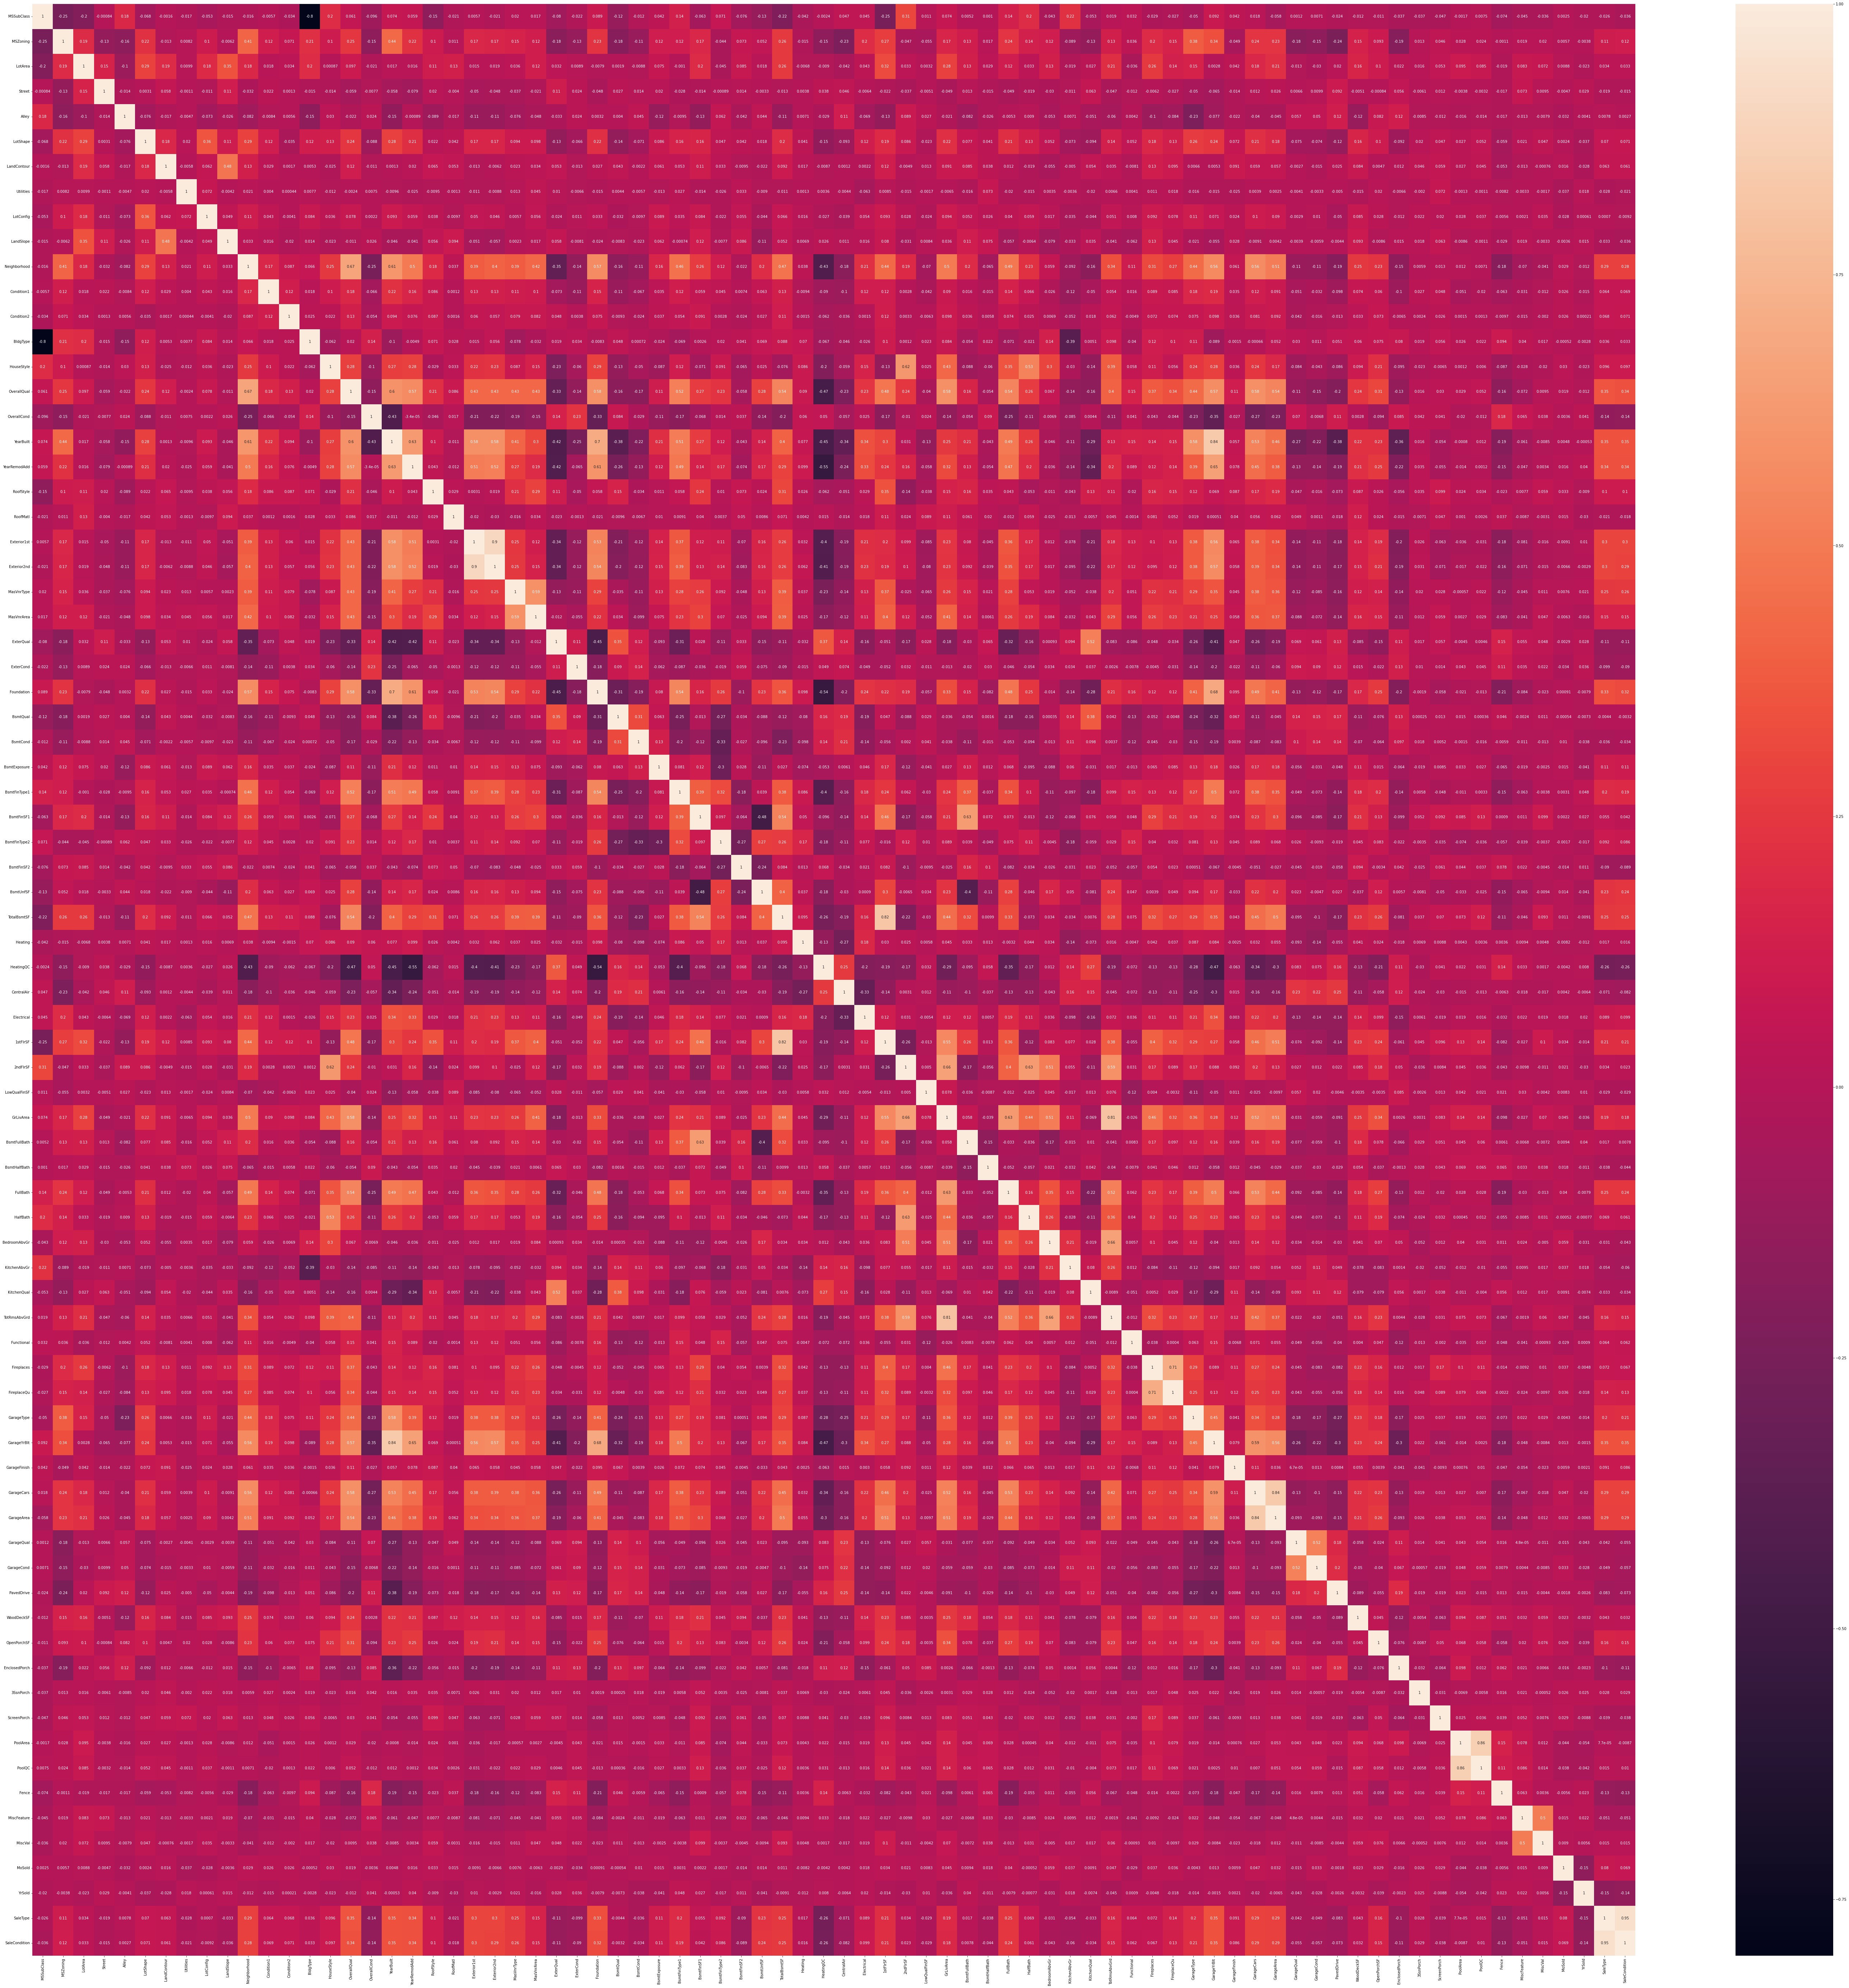

['Exterior2nd', 'SaleCondition']

In [18]:
# We will probably to PCA, so looking at correlations is probably not too important

#plot correlation matrix
plt.figure(figsize=(100,100))
corr_matrix = df_x_encoded.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Take absolute values of correlations and select upper triangle of correlation matrix
upper_matrix = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
correlated_features = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.9)]
correlated_features

In [19]:
#Scale Data
scale = StandardScaler()
df_x_scaled = scale.fit_transform(df_x_encoded)

In [20]:
print("Shape of df_x_scaled:", df_x_scaled.shape)

Shape of df_x_scaled: (2726, 78)


C:\Users\sebas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


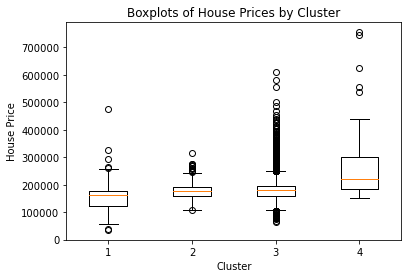

Cluster 1: 454 data points
Cluster 2: 187 data points
Cluster 3: 2020 data points
Cluster 4: 65 data points


In [21]:
#Gaussian Mixture Modelling
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(df_x_scaled)

# Predict the labels for the data
labels = gmm.predict(df_x_scaled)

# Create a list of y values for each cluster
y_cluster = [df_y[labels == i] for i in range(gmm.n_components)]

# Sort clusters in ascending order (by median)
sorted_y_cluster = sorted(y_cluster, key=lambda x: np.median(x))

# Boxplot of clusters
plt.boxplot(sorted_y_cluster)
plt.title("Boxplots of House Prices by Cluster")
plt.xlabel("Cluster")
plt.ylabel("House Price")
plt.show()

# Count number of points in each cluster
for i in range(0,len(sorted_y_cluster)):
    print("Cluster " + str(i+1) + ": " + str(len(sorted_y_cluster[i])) + " data points")  

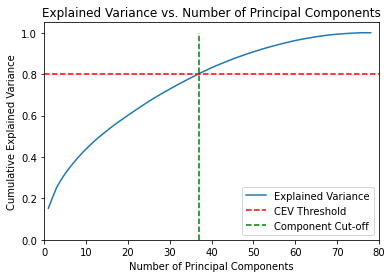

In [45]:
## ILAN, PCA

from sklearn.decomposition import PCA

#Apply PCA to scaled data and compute the variance ratio:
pca = PCA()
pca.fit(df_x_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

#Plot the explained variance ratio as a function of the number of principal components:
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), label='Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.hlines(y=0.8, xmin=0, xmax=80, linestyles='dashed', colors='red', label='CEV Threshold')
plt.vlines(x=37, ymin=0, ymax=1, linestyles='dashed', colors='green', label='Component Cut-off')
plt.xlim((0,80))
plt.ylim((0,1.05))
plt.legend(loc='lower right')
plt.title('Explained Variance vs. Number of Principal Components')
plt.show()

In [23]:
#Determine the number of PC that explain a sufficient proportion of the variance (e.g., 60%)
n_components = np.where(np.cumsum(explained_variance_ratio) >= 0.80)[0][0] + 1

In [49]:
#Perform PCA with the optimal number of principal components:
pca_optimal = PCA(n_components=n_components)
df_x_pca = pca_optimal.fit_transform(df_x_scaled)

In [25]:
# Create a DataFrame with principal components and columns named 'PC1', 'PC2', etc.
df_principal_components = pd.DataFrame(df_x_pca, columns=['PC' + str(i + 1) for i in range(n_components)])

In [26]:
df_principal_components

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37
0,2.905670,-2.810397,0.364792,1.302094,0.679587,-0.224812,0.040935,0.311901,0.399549,-1.474186,...,-0.343369,-0.166281,0.204403,0.240182,0.533366,0.064619,-0.585450,0.235477,0.111460,0.003628
1,-0.806779,1.102608,-0.982609,1.388455,-0.916200,-0.149282,-0.266514,0.999999,0.021633,0.266837,...,-2.215094,0.990606,0.163130,-0.429977,1.528007,-0.148178,0.652623,-0.519570,-0.855280,-1.187656
2,3.342898,-2.140296,0.186844,1.360265,0.501369,0.291338,0.340297,-0.558210,0.374657,-0.926960,...,-0.038244,-0.370159,0.199215,0.831760,-0.064342,-0.276392,-0.144142,0.095208,0.010650,-0.401071
3,-1.040867,0.554801,1.868698,0.586984,-0.061169,-0.363568,0.042477,-0.530021,0.637905,-0.599975,...,-0.667985,0.898257,-0.385001,1.528124,0.177994,2.170093,-0.661085,1.088894,0.951896,0.260847
4,5.830765,-0.597107,1.783696,1.045595,0.740685,0.663858,0.069041,-0.473488,1.026060,-1.282192,...,0.167461,-0.367396,0.601382,0.925555,-0.540085,0.021411,0.069243,-0.260156,-0.576193,0.035937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,-1.272933,1.982364,-1.184740,0.603206,0.090278,2.664173,-0.110422,-0.698375,0.361347,1.211582,...,0.086251,0.051854,1.233169,0.173995,-0.254263,0.305202,0.339746,-0.303820,-1.036748,1.103986
2722,-3.606035,-3.956690,0.674792,0.028254,3.269163,-0.046349,-0.676209,0.356783,-1.660733,1.443355,...,0.616925,-1.147214,0.314624,0.932447,-0.976343,-0.497414,0.475208,1.567168,-0.033019,0.009176
2723,-3.487448,-3.667340,0.925207,0.289961,1.974985,-0.080096,-0.468461,0.222454,-1.404957,0.805368,...,0.054695,-0.900934,0.455932,0.484494,-0.481886,-0.130896,-0.034104,1.107874,-0.060532,0.688660
2724,-0.520747,1.460582,-1.044925,1.333042,-0.266448,-0.323747,-0.197989,-0.155385,-0.016173,-1.136484,...,0.878081,0.035304,1.238551,-0.139500,-0.181446,0.157651,-0.161667,1.124588,-0.284463,-0.306362


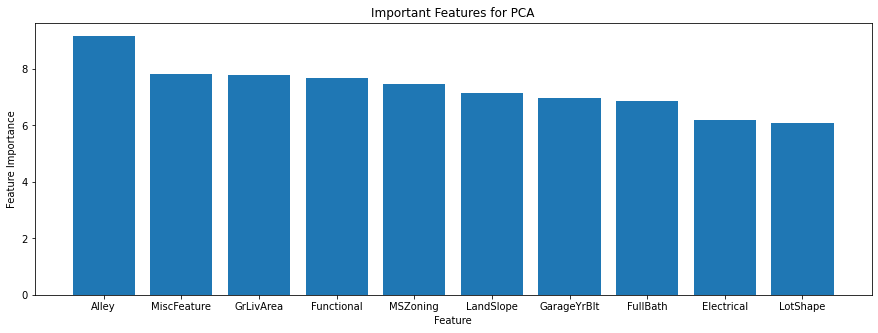

'MSSubClass'

In [77]:
#Important Features for PCA

#Get eigenvectors and eigenvalues
eigenvectors = pca.components_[:, :n_components]
eigenvalues = pca.explained_variance_[:n_components].reshape(-1, 1)

#Calculate feature importance
feature_imp = np.zeros((eigenvectors.shape[0]))
for i in range(0,len(eigenvalues)):
    feature_imp += np.abs(eigenvalues[i] * eigenvectors[:,i])

# Get the indices that would sort the feature_imp in ascending order
sort_ind = np.argsort(feature_imp)

# Select the last 10 indices (corresponding to the largest elements)
largest_feat_ind = sort_ind[-10:]
largest_feat_ind = largest_feat_ind[::-1]  # Reverse order to get largest to smallest

# Get the top 10 elements and their indices
most_imp = feature_imp[largest_feat_ind]

# Get a list of column names corresponding to the selected features
feat_names = list(df_x_encoded.columns[largest_feat_ind])

# Create the bar plot
plt.figure(figsize=(15,5))
plt.bar(range(len(most_imp)), most_imp)
plt.xticks(range(len(feat_names)), feat_names)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Important Features for PCA')
plt.show()